In [19]:
# Basic
import re
import numpy as np
import pandas as pd

# NLP Indo
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

# Word2Vec
from gensim.models import Word2Vec

# Deep Learning - IndoBERT
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
df = pd.read_csv("BCA_labeled_progress.csv")

In [7]:
df

,content,label
0,sayang g bisa digunakan m bca gbisa dipake q b...,-1
1,"jelek aplikasi payah BCA,masak tau tau kluar s...",-1
2,baik,0
3,"suka loading kalau dibuka,, gak bisa sat set l...",-1
4,"Peringatan yang selalu mengganggu ""Transaksi d...",-1
...,...,...
245,"sinyal bagus tapi masih merah , lemot !!!",-1
246,"makin ke sini,makin g jelas . . di buka sinyal...",-1
247,notif merah terus pas saat mau transaksi 29 no...,-1
248,"abis update malah makin ribet, signal merah te...",-1


In [20]:
X = df['content']
y = df['label']

In [21]:
stop_words = set(stopwords.words('indonesian'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text


In [25]:
def preprocess_stemming(text):
    text = clean_text(text)
    tokens = text.split()   # <-- TIDAK PAKAI word_tokenize
    tokens = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)


In [26]:
def preprocess_lemmatization(text):
    text = clean_text(text)
    tokens = text.split()
    tokens = [w for w in tokens if w not in stop_words]
    return " ".join(tokens)


1. **Stemming + TF-IDF + SVM**

In [27]:
X_exp1 = X.apply(preprocess_stemming)

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(X_exp1)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

svm1 = SVC(kernel='linear')
svm1.fit(X_train, y_train)

y_pred = svm1.predict(X_test)
print("EKSPERIMEN 1")
print(classification_report(y_test, y_pred))


EKSPERIMEN 1
              precision    recall  f1-score   support

          -1       0.90      1.00      0.95        44
           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4

    accuracy                           0.88        50
   macro avg       0.30      0.33      0.32        50
weighted avg       0.79      0.88      0.83        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


2. **Lemmatization + TF-IDF + SVM**

In [29]:
X_exp2 = X.apply(preprocess_lemmatization)

X_tfidf = tfidf.fit_transform(X_exp2)

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

svm2 = SVC(kernel='linear')
svm2.fit(X_train, y_train)

y_pred = svm2.predict(X_test)
print("EKSPERIMEN 2")
print(classification_report(y_test, y_pred))


EKSPERIMEN 2
              precision    recall  f1-score   support

          -1       0.90      1.00      0.95        44
           0       0.00      0.00      0.00         2
           1       0.00      0.00      0.00         4

    accuracy                           0.88        50
   macro avg       0.30      0.33      0.32        50
weighted avg       0.79      0.88      0.83        50



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3. **Stemming + Word2Vec + SVM**

In [28]:
X_exp3 = X.apply(preprocess_stemming)
sentences = [t.split() for t in X_exp3]

w2v = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4
)

def w2v_vector(tokens, model):
    vec = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vec, axis=0) if len(vec) > 0 else np.zeros(100)

X_w2v = np.array([w2v_vector(t.split(), w2v) for t in X_exp3])

X_train, X_test, y_train, y_test = train_test_split(
    X_w2v, y, test_size=0.2, random_state=42
)

svm3 = SVC(kernel='rbf')
svm3.fit(X_train, y_train)

y_pred = svm3.predict(X_test)
print("EKSPERIMEN 3")
print(classification_report(y_test, y_pred))


EKSPERIMEN 3
              precision    recall  f1-score   support

          -1       0.96      1.00      0.98        44
           0       1.00      0.50      0.67         2
           1       0.67      0.50      0.57         4

    accuracy                           0.94        50
   macro avg       0.87      0.67      0.74        50
weighted avg       0.94      0.94      0.93        50



4. **Lemmatization + IndoBERT**

In [36]:
df_2 = df.copy()

# Mapping label ke 3 kelas
df_2['label_3class'] = df_2['label'].replace({
    -1: 0,  # negatif
     0: 1,  # netral
     1: 2   # positif
})

In [37]:
print("\nDistribusi label baru (df_2):")
print(df_2['label_3class'].value_counts().sort_index())


Distribusi label baru (df_2):
label_3class
0    212
1     18
2     20
Name: count, dtype: int64


In [38]:
X = df_2['content']
y = df_2['label_3class']


In [39]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained(
    "indobenchmark/indobert-base-p1",
    num_labels=3
)


class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts.tolist(),
            truncation=True,
            padding=True,
            max_length=128
        )
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [40]:
X_exp4 = X.apply(preprocess_lemmatization)

X_train, X_test, y_train, y_test = train_test_split(
    X_exp4, y, test_size=0.2, random_state=42
)

train_ds = Dataset(X_train, y_train)
test_ds = Dataset(X_test, y_test)

args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    logging_steps=10
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=test_ds
)

trainer.train()


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,0.615100
20,0.241300
30,0.243900
40,0.151700
50,0.230300
60,0.125800
70,0.130300


TrainOutput(global_step=75, training_loss=0.23291673978169758, metrics={'train_runtime': 571.3511, 'train_samples_per_second': 1.05, 'train_steps_per_second': 0.131, 'total_flos': 22816866693600.0, 'train_loss': 0.23291673978169758, 'epoch': 3.0})

In [41]:
predictions = trainer.predict(test_ds)

y_pred = predictions.predictions.argmax(axis=1)
y_true = y_test.values


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(
    y_true,
    y_pred,
    target_names=["Negatif", "Netral", "Positif"]
))


              precision    recall  f1-score   support

     Negatif       0.96      1.00      0.98        44
      Netral       1.00      0.50      0.67         2
     Positif       0.67      0.50      0.57         4

    accuracy                           0.94        50
   macro avg       0.87      0.67      0.74        50
weighted avg       0.94      0.94      0.93        50



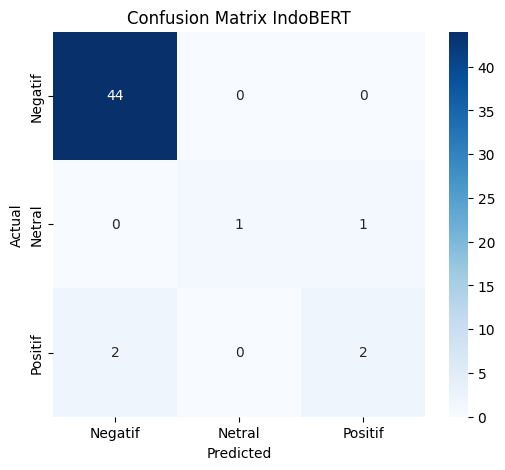

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d",
            cmap="Blues",
            xticklabels=["Negatif","Netral","Positif"],
            yticklabels=["Negatif","Netral","Positif"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix IndoBERT")
plt.show()
